## Creating features

In this notebook, we go through the process of creating features to put into our machine learning model. The goal of this is to create time series of features that we think are good to enter into an LSTM model. At the end, we will try to put this into tensorflow dataset format using this [tutorial](https://www.tensorflow.org/datasets/add_dataset). 


In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# Importing ta library from pandas for technical analysis functions
import pandas_ta as ta

In [2]:
data = pd.read_parquet('btc_usd_1h.parquet')

In [6]:
data.head()

,timestamp,open,high,low,close,volume,trade_count,vwap
0,2021-01-01 06:00:00+00:00,29255.71,29338.25,29153.55,29234.15,42.244289,1243.0,29237.240312
1,2021-01-01 07:00:00+00:00,29235.61,29236.95,28905.00,29162.50,34.506038,1070.0,29078.423185
2,2021-01-01 08:00:00+00:00,29162.50,29248.52,28948.86,29076.77,27.596804,1110.0,29091.465155
3,2021-01-01 09:00:00+00:00,29075.31,29372.32,29058.05,29284.92,20.694200,880.0,29248.730924
4,2021-01-01 10:00:00+00:00,29291.54,29400.00,29232.16,29286.63,16.617646,742.0,29338.609132


The goal of this is to create features which might be useful in predicting the one step ahead closing price of BTC/USD. For now, we will only use information gained from the historical prices here. Not dealing with external pricing informatino. We will brainstorm a bit around this. Let's start with technical indicators that may be useful: 

* **RSI** -> relative strength index over a couple of lookback periods. 
    * This indicator is sort of a tried and true metric for getting a sense of if there will be reversals in the market. Of course, this needs to be used in conjunction with features but should be a good start
* **MACD** -> moving average convergence and divergence. Another very common indicator which traders use. We can explore this a bit. Some more reading on the MACD [here](https://www.investopedia.com/terms/m/macd.asp#:~:text=Moving%20average%20convergence%2Fdivergence%20(MACD%2C%20or%20MAC%2DD,EMAs)%20of%20a%20security's%20price.)
* **Bollinger Bands**
    * We can use the %B column which gives us how close or far away the price is to the upper band
* **Simple moving averages** -> these smooth out the price so that you can focus on trends that are happening
    * Where is the price relative to the simple moving average? -> as percentage of moving average, as z-score away from moving average
    * Relationship of moving averages to each other -> relative difference between longer and shorter moving averages? 
* **Exponential moving averages** -> these moving averages move a little quicker than the simple moving average and can give us a sense of short term price action
    * How far is price from this moving average (normalized)
    * How far is this moving average from a simple moving average potentially? 

I think that's enough of the technical features for now. What are some other features that we can try out? 
* Lagged returns over some period of time --> if you see the sequence of returns, then you can maybe get a guess around what the future momentum might be
* Rolling volatility -> what has been the average squared return? Giving a sense of magnitude that's there
* Open - Close
* High - Low
* On balance volume --> basically an accumlation of volume depending on the direction of price

We will go through each of these features, take a look at them, and understand their properties. Should have a separate technical analysis folder where we write down the different technical features, plot them, and say other things about them. 

### RSI

In [7]:
rsi = ta.rsi(close = data['close'], length = 14)

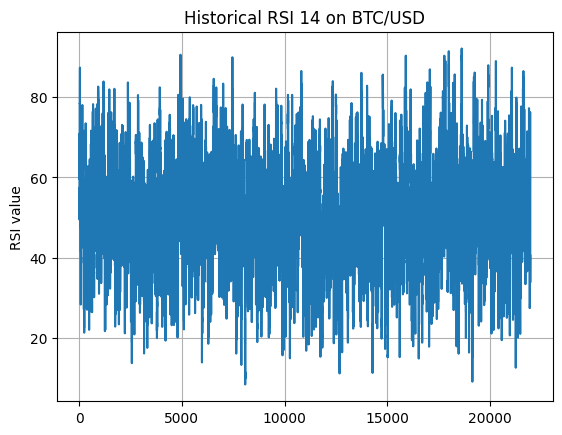

In [11]:
rsi.dropna().plot()
plt.title("Historical RSI 14 on BTC/USD")
plt.ylabel('RSI value')
plt.grid(True) 
plt.show()

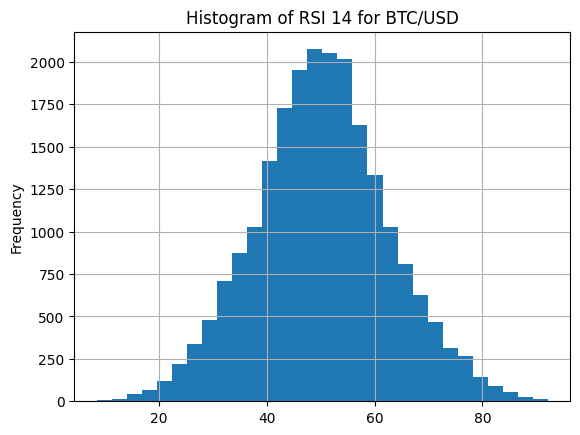

In [14]:
rsi.plot(kind = 'hist', bins = 30)
plt.title("Histogram of RSI 14 for BTC/USD")
plt.grid()
plt.show()

We can see here a couple of things about RSI: 
* It is very mean reverting. It rarely comes above 80 and below 20. 
    * This is by design since the indicator stays between 0 and 100
* The distribution is very gaussian which is nice


### MACD

MACD stands for **M**oving **A**verage **C**onvergence **D**ivergence and is a very popular indicator that traditional technical traders use. To calculate the MACD, we do the following: 
* 

In [15]:
macd = ta.macd(close = data['close'])

In [16]:
macd

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
21949,-7.019350,-41.176787,34.157437
21950,-28.071889,-49.783461,21.711572
21951,-51.744203,-58.764620,7.020417
21952,-71.678314,-62.958985,-8.719329
